In [1]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv("D:/personal/project/clg project/digit recognition/archive/train.csv")
test = pd.read_csv("D:/personal/project/clg project/digit recognition/archive/test.csv")

In [3]:
X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


##exploratory data analysis

In [4]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

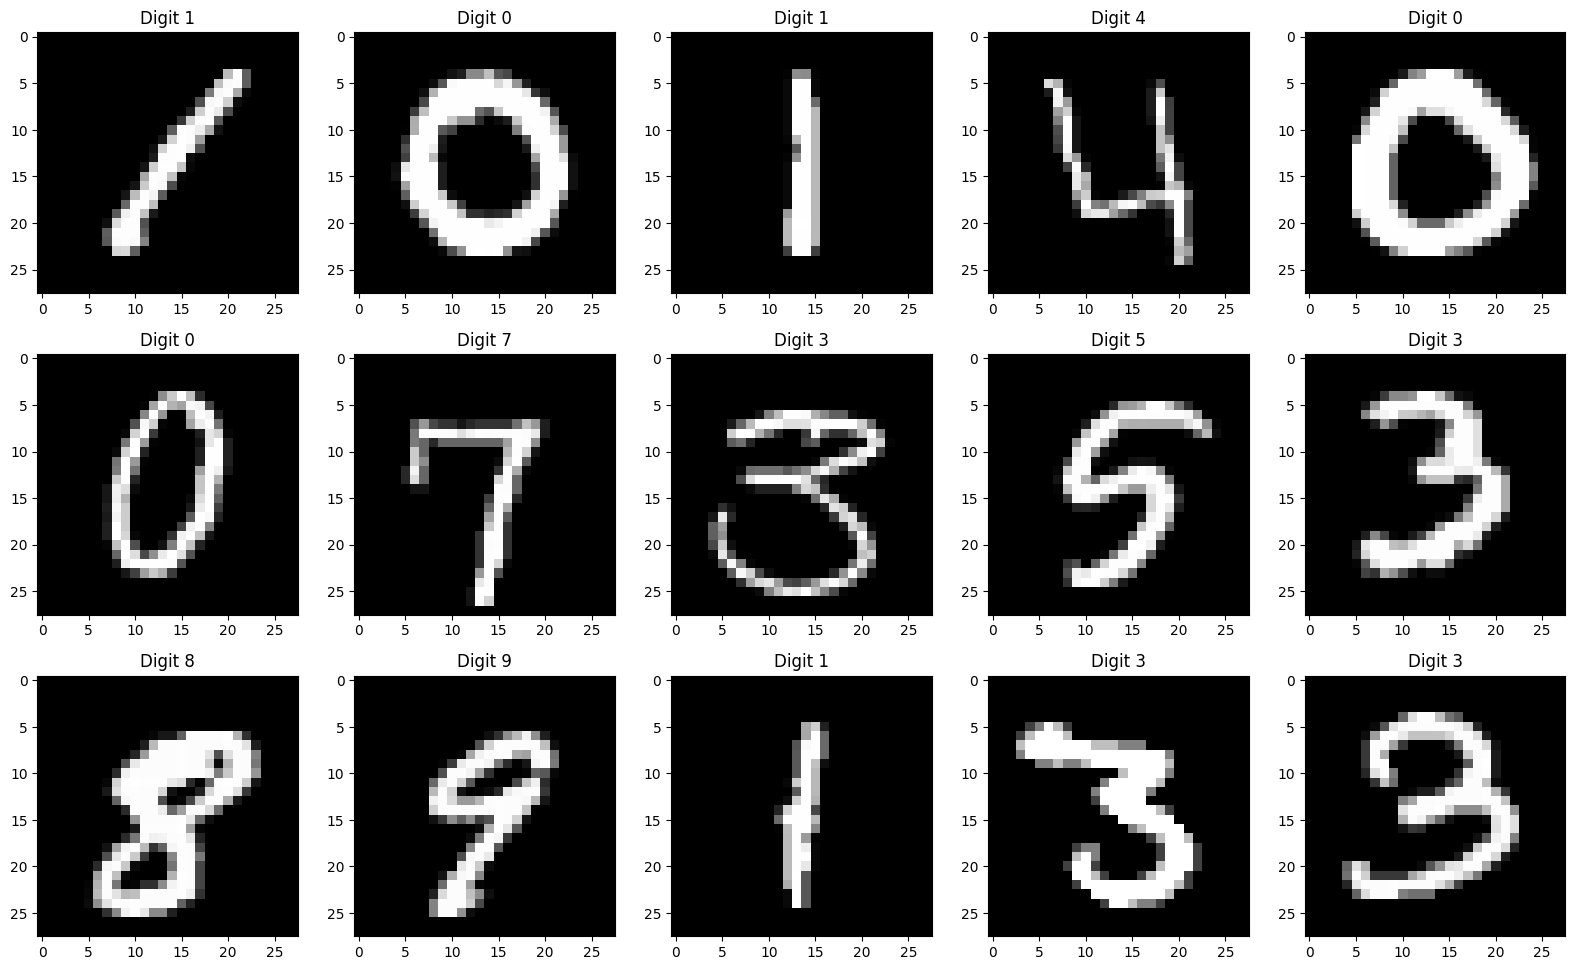

In [5]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
Show_example_digits()

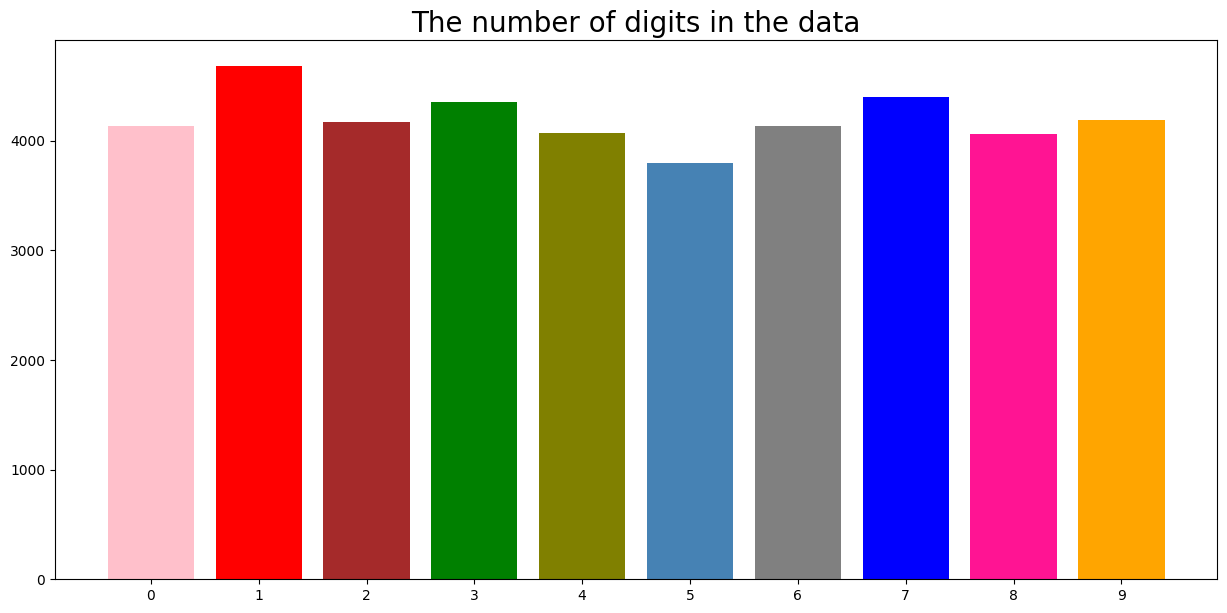

In [6]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

In [7]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

input_shape = (img_rows, img_cols)

In [8]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

In [10]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [12]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint(f'../working/{name}.hdf5', save_best_only=True) # saving the best model
    ]

In [13]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [14]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/40




C:\Users\JiteshMatta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 - 8s - loss: 0.7102 - f1: 0.7061 - val_loss: 0.3294 - val_f1: 0.8989 - lr: 0.0010 - 8s/epoch - 222ms/step
Epoch 2/40
37/37 - 1s - loss: 0.2710 - f1: 0.9235 - val_loss: 0.2444 - val_f1: 0.9320 - lr: 0.0010 - 1s/epoch - 40ms/step
Epoch 3/40
37/37 - 1s - loss: 0.2108 - f1: 0.9417 - val_loss: 0.2071 - val_f1: 0.9408 - lr: 0.0010 - 1s/epoch - 38ms/step
Epoch 4/40
37/37 - 1s - loss: 0.1730 - f1: 0.9520 - val_loss: 0.1745 - val_f1: 0.9472 - lr: 0.0010 - 1s/epoch - 36ms/step
Epoch 5/40
37/37 - 1s - loss: 0.1447 - f1: 0.9608 - val_loss: 0.1557 - val_f1: 0.9528 - lr: 0.0010 - 1s/epoch - 38ms/step
Epoch 6/40
37/37 - 2s - loss: 0.1234 - f1: 0.9666 - val_loss: 0.1395 - val_f1: 0.9543 - lr: 0.0010 - 2s/epoch - 42ms/step
Epoch 7/40
37/37 - 1s - loss: 0.1061 - f1: 0.9715 - val_loss: 0.1295 - val_f1: 0.9584 - lr: 0.0010 - 1s/epoch - 39ms/step
Epoch 8/40
37/37 - 1s - loss: 0.0936 - f1: 0.9754 - val_loss: 0.1184 - val_f1: 0.9638 - lr: 0.0010 - 1s/epoch - 39ms/step
Epoch 9/40
37/37 - 1s - loss: 0.08

In [16]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.457498997449875%
Test score: 97.49501347541809%
MLP Error: 2.50%


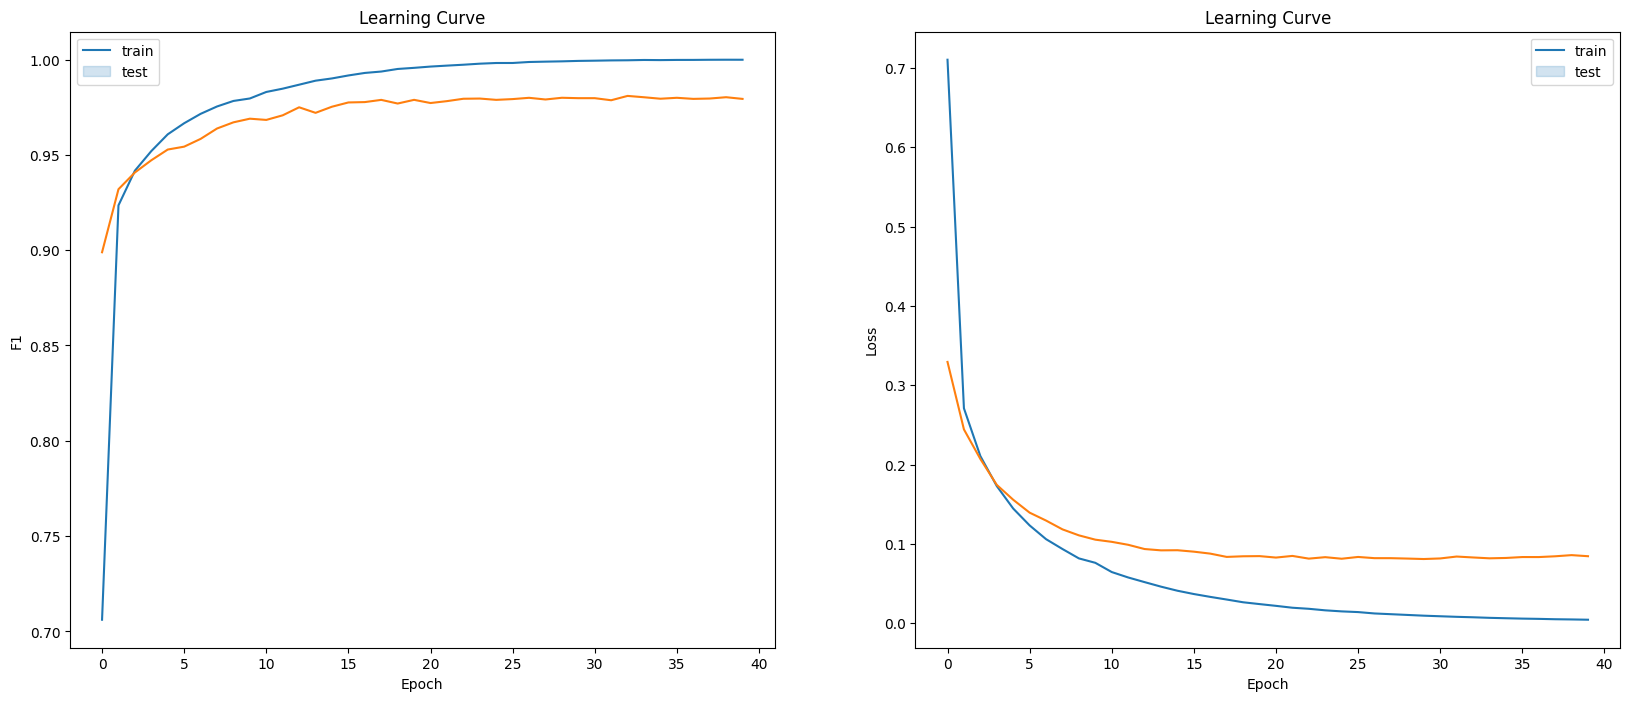

In [17]:
draw_learning_curve(learning_history)

In [18]:
def get_mlpv2():
    
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [19]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 56743

In [20]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40


C:\Users\JiteshMatta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 - 5s - loss: 0.7776 - f1: 0.6814 - val_loss: 0.2792 - val_f1: 0.9165 - lr: 0.0010 - 5s/epoch - 122ms/step
Epoch 2/40
37/37 - 2s - loss: 0.2526 - f1: 0.9261 - val_loss: 0.1728 - val_f1: 0.9452 - lr: 0.0010 - 2s/epoch - 65ms/step
Epoch 3/40
37/37 - 2s - loss: 0.1711 - f1: 0.9484 - val_loss: 0.1314 - val_f1: 0.9555 - lr: 0.0010 - 2s/epoch - 65ms/step
Epoch 4/40
37/37 - 2s - loss: 0.1313 - f1: 0.9601 - val_loss: 0.1057 - val_f1: 0.9674 - lr: 0.0010 - 2s/epoch - 64ms/step
Epoch 5/40
37/37 - 3s - loss: 0.1078 - f1: 0.9677 - val_loss: 0.0964 - val_f1: 0.9665 - lr: 0.0010 - 3s/epoch - 73ms/step
Epoch 6/40
37/37 - 3s - loss: 0.0890 - f1: 0.9730 - val_loss: 0.0847 - val_f1: 0.9699 - lr: 0.0010 - 3s/epoch - 76ms/step
Epoch 7/40
37/37 - 2s - loss: 0.0738 - f1: 0.9782 - val_loss: 0.0789 - val_f1: 0.9767 - lr: 0.0010 - 2s/epoch - 65ms/step
Epoch 8/40
37/37 - 2s - loss: 0.0619 - f1: 0.9808 - val_loss: 0.0701 - val_f1: 0.9803 - lr: 0.0010 - 2s/epoch - 62ms/step
Epoch 9/40
37/37 - 2s - loss: 0.05

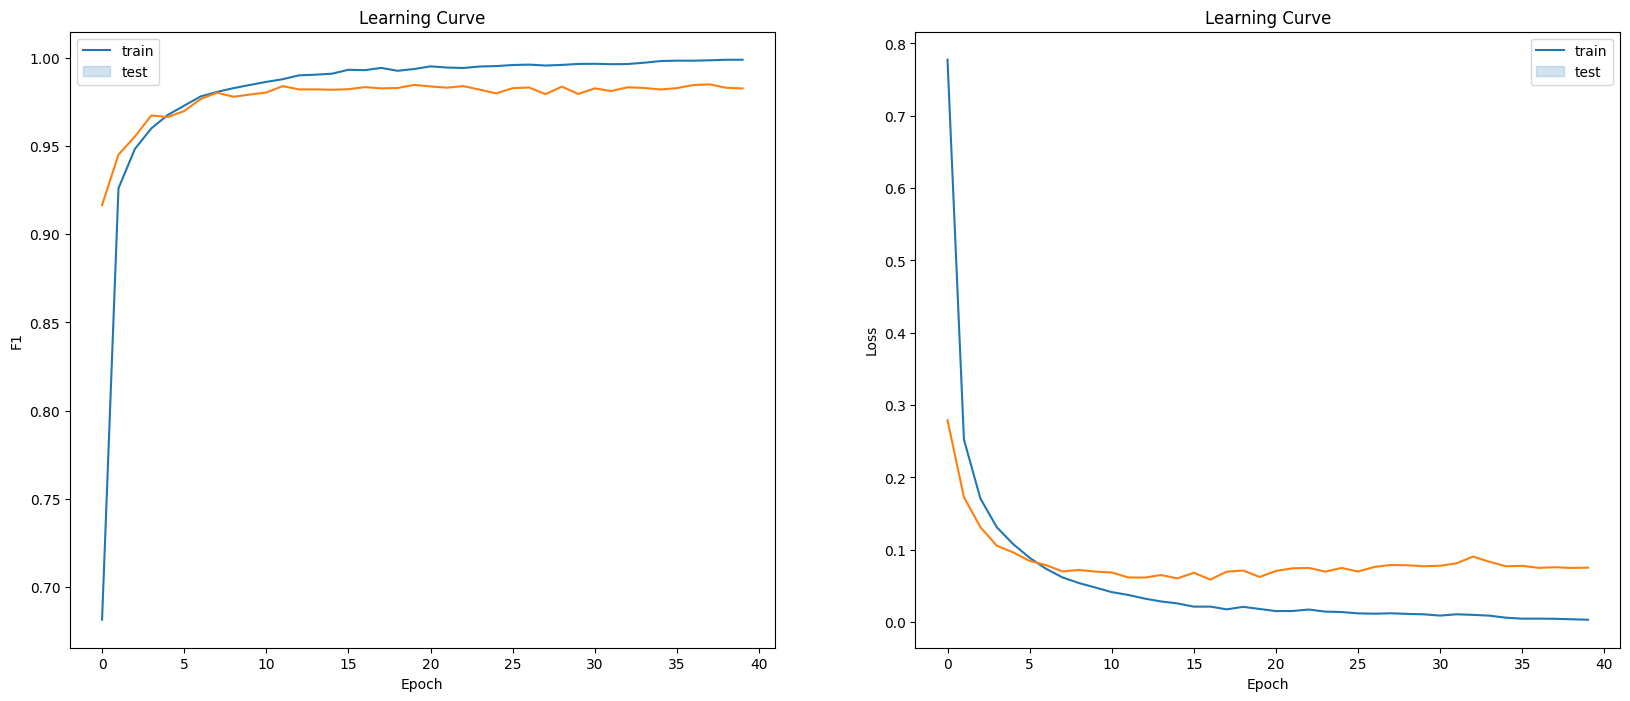

In [21]:
draw_learning_curve(learning_history)

In [22]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 7.537142187356949%
Test score: 98.11620116233826%
MLP Error: 1.88%


In [23]:
X_train.shape

(37800, 784)

In [24]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [25]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [26]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                     

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 45,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/45
296/296 [==============================] - ETA: 0s - loss: 0.4608 - f1: 0.8304

C:\Users\JiteshMatta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 98s 318ms/step - loss: 0.4608 - f1: 0.8304 - val_loss: 0.0624 - val_f1: 0.9805 - lr: 0.0010
Epoch 2/45
296/296 [==============================] - 96s 323ms/step - loss: 0.0968 - f1: 0.9718 - val_loss: 0.0507 - val_f1: 0.9862 - lr: 0.0010
Epoch 3/45
296/296 [==============================] - 83s 281ms/step - loss: 0.0746 - f1: 0.9802 - val_loss: 0.0541 - val_f1: 0.9855 - lr: 0.0010
Epoch 4/45
296/296 [==============================] - 99s 333ms/step - loss: 0.0580 - f1: 0.9830 - val_loss: 0.0366 - val_f1: 0.9900 - lr: 0.0010
Epoch 5/45
296/296 [==============================] - 104s 350ms/step - loss: 0.0459 - f1: 0.9870 - val_loss: 0.0349 - val_f1: 0.9892 - lr: 0.0010
Epoch 6/45
296/296 [==============================] - 99s 335ms/step - loss: 0.0398 - f1: 0.9887 - val_loss: 0.0331 - val_f1: 0.9899 - lr: 0.0010
Epoch 7/45
296/296 [==============================] - 103s 348ms/step - loss: 0.0366 - f1: 0.9896 - val_loss: 0.0277 - val_f1: 0.9918 

In [28]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("models.h5")

In [29]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])
print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.033659156411886215
Test score: 0.9939612150192261
CNN Error: 0.60%


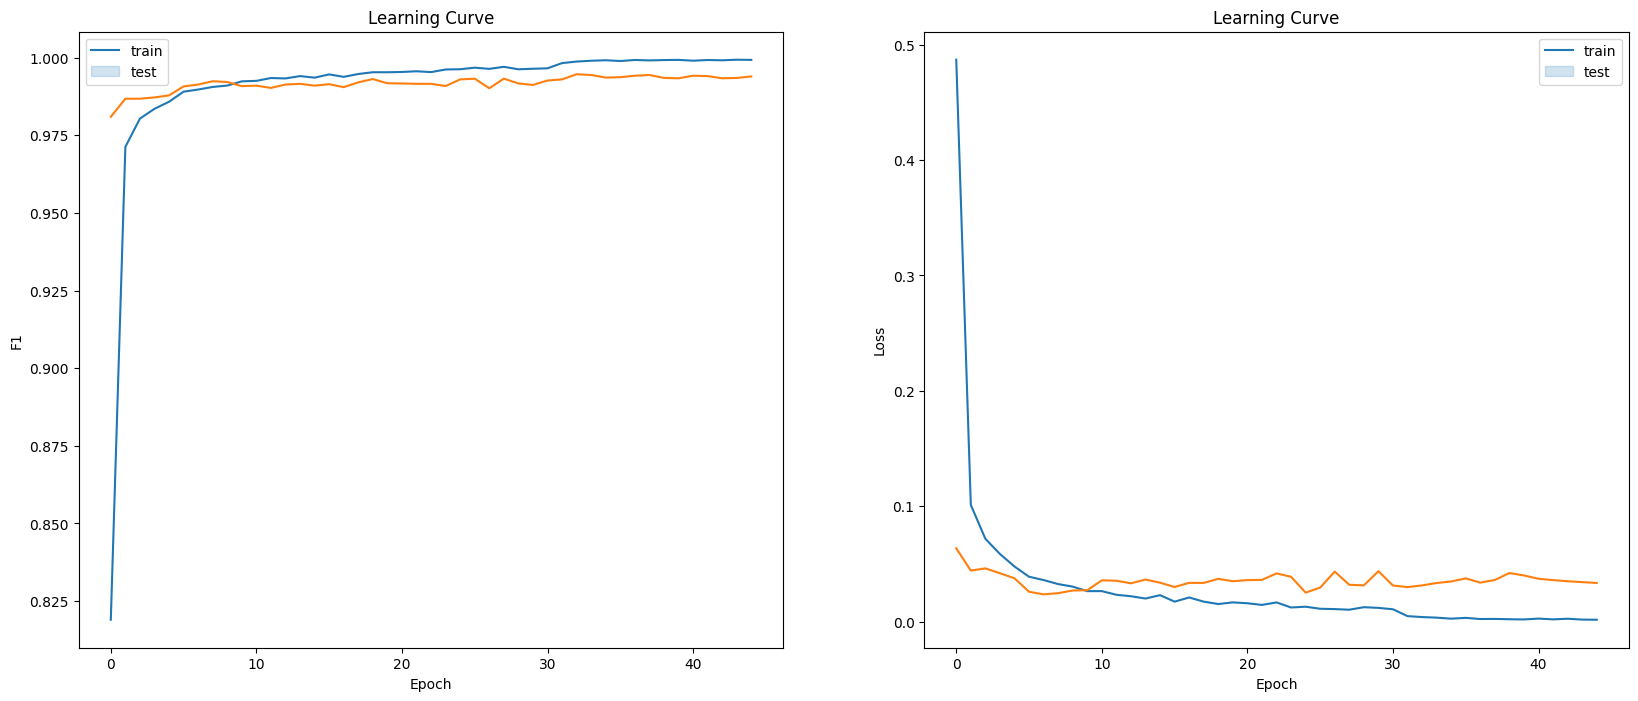

In [30]:
draw_learning_curve(learning_history) 

In [31]:
y_pred = model.predict(X_val)

132/132 [==============================] - 3s 19ms/step


In [32]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        
        cnt += 1

C:\Users\JiteshMatta\AppData\Local\Temp\ipykernel_6568\854454831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=cnt_error[0],y=cnt_error[1], palette="ch:s=.25,rot=-.25")


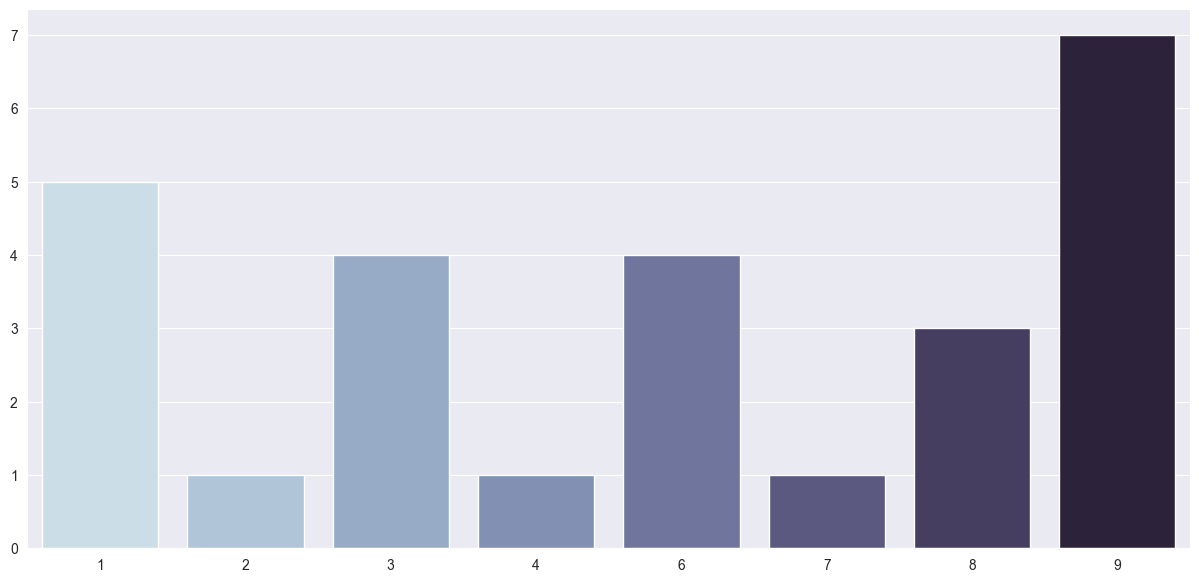

In [33]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    else:
        cnt_error.append((np.argmax(a)))
cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(x=cnt_error[0],y=cnt_error[1], palette="ch:s=.25,rot=-.25")
plt.show()

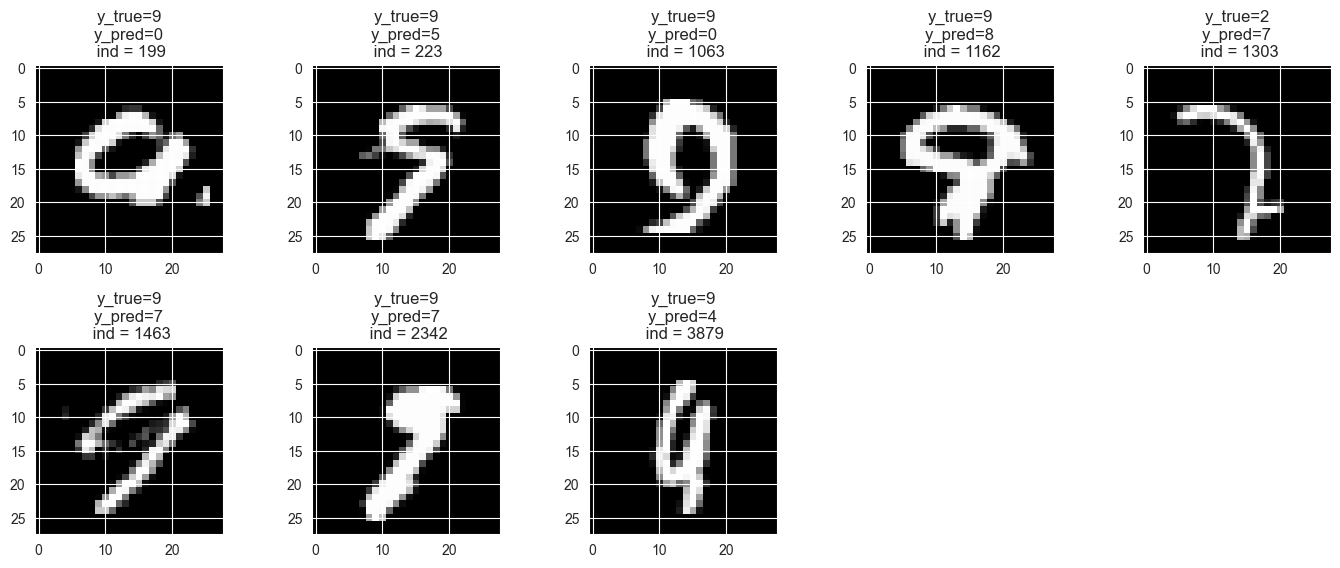

In [34]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):    
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

In [2]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

NameError: name 'model' is not defined

In [1]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'/D:/personal/project/clg project/digit recognition/')

NameError: name 'model' is not defined